## Handwriting Recognition using CRNN in Keras

Here we demonstrate how to use the EZKL package to build an Handwriting Recognition using CRNN in Keras for on-chain handrawn digit recognition.
The proofs get submitted to a contract that assigns the users account to a digit clan (0-9).


In [1]:
# check if notebook is in colab
try:
    # install ezkl
    import google.colab
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "ezkl"])
    subprocess.check_call([sys.executable, "-m", "pip", "install", "torch"])
    subprocess.check_call([sys.executable, "-m", "pip", "install", "torchvision"])
    subprocess.check_call([sys.executable, "-m", "pip", "install", "tf2onnx"])
    subprocess.check_call([sys.executable, "-m", "pip", "install", "onnx"])

# rely on local installation of ezkl if the notebook is not in colab
except:
    pass

# make sure you have the dependencies required here already installed
import ezkl
import os
import json
import time
import random
import logging


# uncomment for more descriptive logging
FORMAT = '%(levelname)s %(name)s %(asctime)-15s %(filename)s:%(lineno)d %(message)s'
logging.basicConfig(format=FORMAT)
logging.getLogger().setLevel(logging.INFO)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # Convolutional encoder
        self.conv1 = nn.Conv2d(1, 6, 5)  # 1 input channel, 6 output channels, 5x5 kernel
        self.conv2 = nn.Conv2d(6, 16, 5) # 6 input channels, 16 output channels, 5x5 kernel

        # Fully connected layers / Dense block
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)         # 120 inputs, 84 outputs
        self.fc3 = nn.Linear(84, 10)          # 84 inputs, 10 outputs (number of classes)

    def forward(self, x):
        # Convolutional block
        x = F.avg_pool2d(F.sigmoid(self.conv1(x)), (2, 2)) # Convolution -> Sigmoid -> Avg Pool
        x = F.avg_pool2d(F.sigmoid(self.conv2(x)), (2, 2)) # Convolution -> Sigmoid -> Avg Pool

        # Flattening
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = self.fc3(x)  # No activation function here, will use CrossEntropyLoss later
        return x


In [3]:
import numpy as np
import os
import torch
from torchvision.datasets import mnist
from torch.nn import CrossEntropyLoss
from torch.optim import Adam  # Import Adam
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

def normalize_img(image, label):
  return torch.round(image), label

device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = 256
train_dataset = mnist.MNIST(root='./train', train=True, transform=ToTensor(), download=True)
test_dataset = mnist.MNIST(root='./test', train=False, transform=ToTensor(), download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
model = LeNet().to(device)
adam = Adam(model.parameters())  # Using Adam with a learning rate of 1e-3
loss_fn = CrossEntropyLoss()
all_epoch = 25
prev_acc = 0
for current_epoch in range(all_epoch):
    model.train()
    for idx, (train_x, train_label) in enumerate(train_loader):
        train_x = train_x.to(device)
        # normalize the image to 0 or 1 to reflect the inputs from the drawing board
        train_x = train_x.round()
        train_label = train_label.to(device)
        adam.zero_grad()  # Use adam optimizer
        predict_y = model(train_x.float())
        loss = loss_fn(predict_y, train_label.long())
        loss.backward()
        adam.step()  # Use adam optimizer
    all_correct_num = 0
    all_sample_num = 0
    model.eval()

    for idx, (test_x, test_label) in enumerate(test_loader):
        test_x = test_x.to(device)
         # normalize the image to 0 or 1 to reflect the inputs from the drawing board
        test_x = test_x.round()
        test_label = test_label.to(device)
        predict_y = model(test_x.float()).detach()
        predict_y = torch.argmax(predict_y, dim=-1)
        current_correct_num = predict_y == test_label
        all_correct_num += np.sum(current_correct_num.to('cpu').numpy(), axis=-1)
        all_sample_num += current_correct_num.shape[0]
    acc = all_correct_num / all_sample_num
    print('test accuracy: {:.3f}'.format(acc), flush=True)
    if not os.path.isdir("models"):
        os.mkdir("models")
    torch.save(model, 'models/mnist_{:.3f}.pkl'.format(acc))
    prev_acc = acc


100%|██████████| 9.91M/9.91M [00:00<00:00, 37.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.17MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.19MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.69MB/s]
100%|██████████| 9.91M/9.91M [00:00<00:00, 37.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.22MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.5MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.91MB/s]


test accuracy: 0.729
test accuracy: 0.860
test accuracy: 0.898
test accuracy: 0.916
test accuracy: 0.929
test accuracy: 0.938
test accuracy: 0.945
test accuracy: 0.951
test accuracy: 0.957
test accuracy: 0.961
test accuracy: 0.964
test accuracy: 0.967
test accuracy: 0.969
test accuracy: 0.971
test accuracy: 0.972
test accuracy: 0.973
test accuracy: 0.974
test accuracy: 0.974
test accuracy: 0.975
test accuracy: 0.976
test accuracy: 0.977
test accuracy: 0.977
test accuracy: 0.978
test accuracy: 0.978
test accuracy: 0.979


tensor(2.0668e-06, grad_fn=<MinBackward1>)


Text(0.5, 1.0, 'Absolute value of parameters')

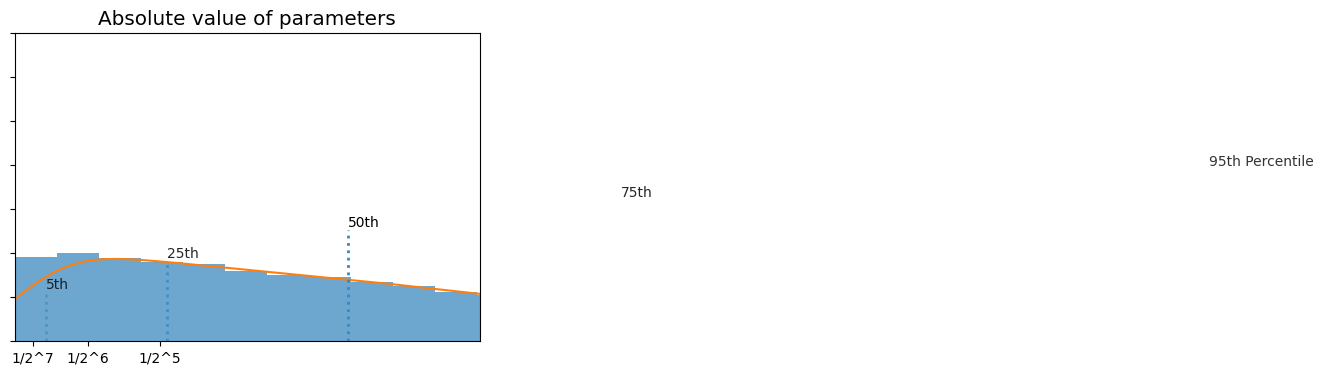

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from scipy import stats
n_bins = 100
# whats the smallest parameter in this model ?
minimum_abs_val = 100000
params_abs = []
for param in model.parameters():
  if param.abs().min() < minimum_abs_val:
    minimum_abs_val = param.abs().min()
  params_abs.extend(param.abs().detach().numpy().flatten().tolist())

print(minimum_abs_val)

xx = np.linspace(0, 0.2, 1000)

kde = stats.gaussian_kde(params_abs)
fig, ax = plt.subplots(figsize = (6,4))

ax.set_xlim(0, 0.2)

# N is the count in each bin, bins is the lower-limit of the bin
N, bins, patches = ax.hist(params_abs, bins=n_bins, density = True, alpha =0.65)
ax.plot(xx, kde(xx))


ax.set_ylim(0, 14)
ax.set_yticklabels([])
ax.set_ylabel("")
plt.style.use("bmh")
ax.set_xticks([1.0/128.0, 1.0/32.0, 1.0/16.0])
ax.set_xticklabels(["1/2^7", "1/2^6", "1/2^5"])
ax.grid(False)
# Calculate percentiles
quant_5, quant_25, quant_50, quant_75, quant_95 = np.quantile(params_abs, 0.05), np.quantile(params_abs, 0.25), np.quantile(params_abs, 0.5), np.quantile(params_abs, 0.75), np.quantile(params_abs, 0.95)

# [quantile, opacity, length]
quants = [[quant_5, 0.6, 0.16], [quant_25, 0.8, 0.26], [quant_50, 1, 0.36],  [quant_75, 0.8, 0.46], [quant_95, 0.6, 0.56]]

# Plot the lines with a loop
for i in quants:
    ax.axvline(i[0], alpha = i[1], ymax = i[2], linestyle = ":")

# Annotations
ax.text(quant_5, 14 * 0.17, "5th", size = 10, alpha = 0.8)
ax.text(quant_25, 14 * 0.27, "25th", size = 10, alpha = 0.85)
ax.text(quant_50, 14 * 0.37, "50th", size = 10, alpha = 1)
ax.text(quant_75, 14 * 0.47, "75th", size = 10, alpha = 0.85)
ax.text(quant_95, 14 * 0.57, "95th Percentile", size = 10, alpha =.8)

ax.set_title("Absolute value of parameters")

In [5]:
import os

model_path = os.path.join('network_lenet.onnx')
compiled_model_path = os.path.join('network.compiled')
pk_path = os.path.join('key.pk')
vk_path = os.path.join('key.vk')
settings_path = os.path.join('settings.json')
witness_path = os.path.join('witness.json')
data_path = os.path.join('input.json')

In [6]:
import torch
import json

model.eval()  # Set the model to evaluation mode

# # Fetch a single data point from the train_dataset
# # Ensure train_dataset is already loaded and accessible
train_data_point, _ = next(iter(train_dataset))
train_data_point = train_data_point.unsqueeze(0)  # Add a batch dimension

# Verify the device (CPU or CUDA) and transfer the data point to the same device as the model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_data_point = train_data_point.to(device)

# # Export the model to ONNX format
torch.onnx.export(model, train_data_point, model_path, export_params=True, opset_version=12, do_constant_folding=True, input_names=['input_0'], output_names=['output'])

# Convert the tensor to numpy array and reshape it for JSON serialization
x = train_data_point.cpu().detach().numpy().reshape([-1]).tolist()
data = {'input_data': [x]}
with open('input.json', 'w') as f:
    json.dump(data, f)

print(f"Model exported to {model_path} and input data saved to input.json")

Model exported to network_lenet.onnx and input data saved to input.json


In [7]:
import ezkl

run_args = ezkl.PyRunArgs()
run_args.input_visibility = "private"
run_args.param_visibility = "fixed"
run_args.output_visibility = "public"
run_args.num_inner_cols = 2
run_args.variables = [("batch_size", 1)]

# Capture set of data points
num_data_points = 8

# Fetch 30 data points from the train_dataset
data_points = []
for i, (data_point, _) in enumerate(train_dataset):
    if i >= num_data_points:
        break
    data_points.append(data_point)

# Stack the data points to create a batch
train_data_batch = torch.stack(data_points)

# Add a batch dimension if not already present
if train_data_batch.dim() == 3:
    train_data_batch = train_data_batch.unsqueeze(0)

x = train_data_batch.cpu().detach().numpy().reshape([-1]).tolist()

data = dict(input_data = [x])

cal_path = os.path.join('cal_data.json')

# Serialize data into file:
json.dump( data, open(cal_path, 'w' ))

!RUST_LOG=trace
# TODO: Dictionary outputs
res = ezkl.gen_settings(model_path, settings_path, py_run_args=run_args)
assert res == True

res = await ezkl.calibrate_settings(cal_path, model_path, settings_path, "resources", scales=[2,7])
assert res == True

INFO:ezkl.execute:num calibration batches: 8
INFO:tract_linalg.x86_64_fma:qmmm_i32: x86_64/avx2 activated
INFO:tract_linalg.x86_64_fma:found f16c, added fake-f16 and q40-able kernels
INFO:tract_linalg.x86_64_fma:mmm_f32, mmv_f32, sigmoid_f32, tanh_f32: x86_64/fma activated
ERROR:ezkl.execute:forward pass failed: "failed to forward: [circuit] [tensor] decomposition error: integer -746694384330 is too large to be represented by base 16384 and n 2"
ERROR:ezkl.execute:forward pass failed: "failed to forward: [circuit] [tensor] decomposition error: integer -23755258519395 is too large to be represented by base 16384 and n 2"

 <------------- Numerical Fidelity Report (input_scale: 2, param_scale: 2, scale_input_multiplier: 10) ------------->

+-------------+--------------+-----------+-----------+----------------+------------------+---------------+---------------+--------------------+--------------------+------------------------+
| mean_error  | median_error | max_error | min_error | mean_ab

In [8]:
res = ezkl.compile_circuit(model_path, compiled_model_path, settings_path)
assert res == True

In [9]:
# srs path
res = await ezkl.get_srs(settings_path)

INFO:ezkl.execute:SRS does not exist, downloading...
INFO:ezkl.execute:Saving SRS to disk...
INFO:ezkl.execute:Saved SRS to /root/.ezkl/srs/kzg18.srs.
INFO:ezkl.execute:SRS downloaded
INFO:ezkl.execute:read 33554692 bytes from file (vector of len = 33554692)
INFO:ezkl.execute:file hash: d0148475717a2ba269784a178cb0ab617bc77f16c58d4a3cbdfe785b591c7034


In [10]:
# now generate the witness file
witness_path = "witness.json"

res = await ezkl.gen_witness(data_path, compiled_model_path, witness_path)
assert os.path.isfile(witness_path)

In [11]:
res = ezkl.mock(witness_path, compiled_model_path)
assert res == True

INFO:ezkl.execute:Mock proof
INFO:ezkl.graph.model:model layout...
INFO:ezkl.circuit.table:Generating lookup table and saving to cache: "/root/.ezkl/cache/sigmoid_16_-14532_247603"
INFO:ezkl.circuit.table:Generating lookup table and saving to cache: "/root/.ezkl/cache/sigmoid_64_-14532_247603"
INFO:ezkl.circuit.table:Generating lookup table and saving to cache: "/root/.ezkl/cache/sigmoid_256_-14532_247603"
INFO:ezkl.circuit.table:Generating lookup table and saving to cache: "/root/.ezkl/cache/sigmoid_1024_-14532_247603"
INFO:ezkl.circuit.table:Generating range check table and saving to cache: "/root/.ezkl/cache/rangecheck_-1_1"
INFO:ezkl.circuit.table:Generating range check table and saving to cache: "/root/.ezkl/cache/rangecheck_0_16383"


In [12]:

# HERE WE SETUP THE CIRCUIT PARAMS
# WE GOT KEYS
# WE GOT CIRCUIT PARAMETERS
# EVERYTHING ANYONE HAS EVER NEEDED FOR ZK

res = ezkl.setup(
        compiled_model_path,
        vk_path,
        pk_path,
    )

assert res == True
assert os.path.isfile(vk_path)
assert os.path.isfile(pk_path)
assert os.path.isfile(settings_path)

INFO:ezkl.graph.model:model layout...
INFO:ezkl.circuit.table:Loading lookup table from cache: "/root/.ezkl/cache/sigmoid_16_-14532_247603"
INFO:ezkl.circuit.table:Loading lookup table from cache: "/root/.ezkl/cache/sigmoid_64_-14532_247603"
INFO:ezkl.circuit.table:Loading lookup table from cache: "/root/.ezkl/cache/sigmoid_256_-14532_247603"
INFO:ezkl.circuit.table:Loading lookup table from cache: "/root/.ezkl/cache/sigmoid_1024_-14532_247603"
INFO:ezkl.circuit.table:Loading range check table from cache: "/root/.ezkl/cache/rangecheck_-1_1"
INFO:ezkl.circuit.table:Loading range check table from cache: "/root/.ezkl/cache/rangecheck_0_16383"
INFO:ezkl.pfsys:VK took 30.205
INFO:ezkl.graph.model:model layout...
INFO:ezkl.circuit.table:Loading lookup table from cache: "/root/.ezkl/cache/sigmoid_16_-14532_247603"
INFO:ezkl.circuit.table:Loading lookup table from cache: "/root/.ezkl/cache/sigmoid_64_-14532_247603"
INFO:ezkl.circuit.table:Loading lookup table from cache: "/root/.ezkl/cache/sig

In [13]:
# GENERATE A PROOF


proof_path = os.path.join('test.pf')

res = ezkl.prove(
        witness_path,
        compiled_model_path,
        pk_path,
        proof_path,
        "single",
    )

print(res)
assert os.path.isfile(proof_path)

INFO:ezkl.pfsys:loaded proving key in 3.25071315s
INFO:ezkl.pfsys:proof started...
INFO:ezkl.graph.model:model layout...
INFO:ezkl.circuit.table:Loading lookup table from cache: "/root/.ezkl/cache/sigmoid_16_-14532_247603"
INFO:ezkl.circuit.table:Loading lookup table from cache: "/root/.ezkl/cache/sigmoid_64_-14532_247603"
INFO:ezkl.circuit.table:Loading lookup table from cache: "/root/.ezkl/cache/sigmoid_256_-14532_247603"
INFO:ezkl.circuit.table:Loading lookup table from cache: "/root/.ezkl/cache/sigmoid_1024_-14532_247603"
INFO:ezkl.circuit.table:Loading range check table from cache: "/root/.ezkl/cache/rangecheck_-1_1"
INFO:ezkl.circuit.table:Loading range check table from cache: "/root/.ezkl/cache/rangecheck_0_16383"
INFO:ezkl.pfsys:proof took 156.631


{'instances': [['05a6ffef93f5e1439170b97948e833285d588181b64550b829a031e1724e6430', '3bdcffef93f5e1439170b97948e833285d588181b64550b829a031e1724e6430', 'a9b7ffef93f5e1439170b97948e833285d588181b64550b829a031e1724e6430', '4259000000000000000000000000000000000000000000000000000000000000', 'a577ffef93f5e1439170b97948e833285d588181b64550b829a031e1724e6430', '7176000000000000000000000000000000000000000000000000000000000000', 'c9b0ffef93f5e1439170b97948e833285d588181b64550b829a031e1724e6430', '6adbffef93f5e1439170b97948e833285d588181b64550b829a031e1724e6430', '72d6ffef93f5e1439170b97948e833285d588181b64550b829a031e1724e6430', '93e6ffef93f5e1439170b97948e833285d588181b64550b829a031e1724e6430']], 'proof': '0x0254087cfb1e863bdd57addf493475018e86cc925ba61a896c654dce3f413bc52b0e4a6545e964c2c4e92526946bff86209c62033b969ae6733d1a16adfc42d111d303041e6f9ddb3f46ece0fa9dda9c352f5d6f85c6e6d4e95d500537f5282924f5bb91e1e252bc9094e20a30b249be1d04da738501889a77b75077cbdcb90818205fa1ef84ec436a1aada2f8c62c8bc6

In [14]:
# VERIFY IT
res = ezkl.verify(
        proof_path,
        settings_path,
        vk_path,
    )

assert res == True
print("verified")

INFO:ezkl.pfsys:loaded verification key ✅
INFO:ezkl.execute:verify took 0.8
INFO:ezkl.execute:verified: true


verified


We can now create an EVM / `.sol` verifier that can be deployed on chain to verify submitted proofs using a view function.

In [29]:

abi_path = 'test.abi'
sol_code_path = 'test_1.sol'

res = await ezkl.create_evm_verifier(
        vk_path,
        settings_path,
        sol_code_path,
        abi_path,
    )
assert res == True

INFO:ezkl.pfsys:loaded verification key ✅


In [32]:
!pip install web3
from web3 import Web3

# Replace with your Sepolia RPC URL (e.g., from Infura)
sepolia_rpc = "https://white-capable-scion.ethereum-sepolia.quiknode.pro/8af1568339092836e95b09d55a0fce41c5178639/"
w3 = Web3(Web3.HTTPProvider(sepolia_rpc))

# If your node or provider returns accounts, print them:
private_key = ""
account = w3.eth.account.from_key(private_key)
print("Current account(s):", account.address)


Current account(s): 0x2A34456FcB3b43275DF03A0402868CE8da6C104a


## Verify on the evm

In [47]:
# Make sure anvil is running locally first
# run with $ anvil -p 3030
# we use the default anvil node here
import json

address_path = os.path.join("address.json")

res = await ezkl.deploy_evm(
    address_path,
    sol_code_path,
    'https://white-capable-scion.ethereum-sepolia.quiknode.pro/8af1568339092836e95b09d55a0fce41c5178639/',
    private_key = private_key
)

assert res == True

with open(address_path, 'r') as file:
    addr = file.read().rstrip()

INFO:ezkl.eth:using chain 11155111
INFO:ezkl.execute:Contract deployed at: 0xe68b9119ed48ffac3f0f5e3510be45124fffd6b1


In [48]:
# make sure anvil is running locally
# $ anvil -p 3030

res = await ezkl.verify_evm(
    addr,
    proof_path,
    "https://white-capable-scion.ethereum-sepolia.quiknode.pro/8af1568339092836e95b09d55a0fce41c5178639/"
)
assert res == True

INFO:ezkl.eth:using chain 11155111
INFO:ezkl.eth:estimated verify gas cost: 804579
INFO:ezkl.execute:Solidity verification result: true


In [49]:
with open("test_1.sol", "r") as file:
    sol_code = file.read()
print(sol_code)


// SPDX-License-Identifier: MIT

pragma solidity ^0.8.0;

contract Halo2Verifier {
    uint256 internal constant    DELTA = 4131629893567559867359510883348571134090853742863529169391034518566172092834;
    uint256 internal constant        R = 21888242871839275222246405745257275088548364400416034343698204186575808495617; 

    uint256 internal constant FIRST_QUOTIENT_X_CPTR = 0x08e4;
    uint256 internal constant  LAST_QUOTIENT_X_CPTR = 0x09a4;

    uint256 internal constant                VK_MPTR = 0x05a0;
    uint256 internal constant         VK_DIGEST_MPTR = 0x05a0;
    uint256 internal constant     NUM_INSTANCES_MPTR = 0x05c0;
    uint256 internal constant                 K_MPTR = 0x05e0;
    uint256 internal constant             N_INV_MPTR = 0x0600;
    uint256 internal constant             OMEGA_MPTR = 0x0620;
    uint256 internal constant         OMEGA_INV_MPTR = 0x0640;
    uint256 internal constant    OMEGA_INV_TO_L_MPTR = 0x0660;
    uint256 internal constant   HAS_ACCUMULATOR